In [7]:
# So we can import our modules 
import sys
sys.path.append('../..')

from src.utils.data import load_split, get_transforms
from src.utils.model import init_model, predict
from src.datasets.pornography_frame_dataset import PornographyFrameDataset

import numpy as np

import torch
from torch.utils.data import DataLoader

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.gradcam import GradCAM
from omnixai.explainers.vision.specific.smoothgrad import SmoothGrad
from omnixai.explainers.vision.specific.ig import IntegratedGradientImage
from omnixai.explainers.vision import ContrastiveExplainer, CounterfactualExplainer


In [8]:
MODEL_NAME = "vgg19"
MODEL_PATH = "../../p2k-even-20-aug-models/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model = init_model(MODEL_NAME)
model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

model.eval()

Device: cpu


DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [9]:
# TODO: check this
last_conv_layer = model.module.features[-3]

In [10]:
DATA_LOC = "../../p2k-even-20-test"
INPUT_SHAPE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
SPLIT = [0.1, 0.2]
BATCH_SIZE = 4
CLASS_NAMES = ["Non-porn", "Porn"]

df_test = load_split(DATA_LOC, SPLIT, ["test"])["test"]
data_transforms = get_transforms(False, INPUT_SHAPE, MEAN, STD)["test"]
dataset = PornographyFrameDataset(DATA_LOC, df_test)
dataloader = DataLoader(dataset, BATCH_SIZE)

Loaded split.
test: total (8000); porn (4020); non-porn (3980)


interesting:
- "vPorn000224#1.jpg" why is it now predicting the wrong label??

In [11]:
name, frame, label = dataset["vPorn000224#1.jpg"]
input = data_transforms(image=frame)["image"].unsqueeze(0).to(device)
with torch.no_grad():
  conf, pred = predict(model, input)
  print(f"{name} - predicted: {pred.item()} (confidence: {conf.item()})")

vPorn000224#1.jpg - predicted: 0 (confidence: 0.9173173904418945)


[<Figure size 640x480 with 2 Axes>]

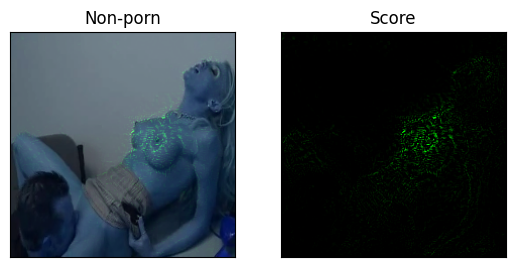

In [6]:
X, y = Image(frame), pred

preprocess = lambda input: data_transforms(image=input.to_numpy().squeeze(0))["image"].unsqueeze(0)

baseline = np.zeros_like(frame)
ig = IntegratedGradientImage(model, preprocess_function=preprocess, background_data=Image(baseline))
ig_explanation = ig.explain(X, y)
ig_explanation.plot(class_names=CLASS_NAMES)

In [57]:
X, y = Image(frame), pred

preprocess = lambda input: data_transforms(image=input.to_numpy().squeeze(0))["image"].unsqueeze(0)

cf = CounterfactualExplainer(model, preprocess_function=preprocess)
cf_explanation = cf.explain(X)

Binary step: 5 |███████████████████████████████████████-| 99.0% 

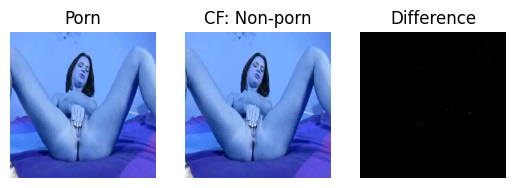

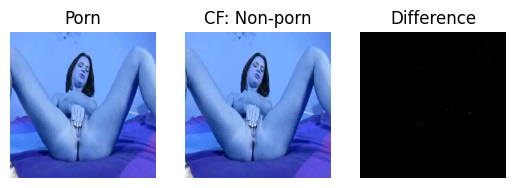

In [58]:
cf_explanation.plot(class_names=CLASS_NAMES)

In [27]:
name, frame, label = dataset["vPorn000224#1.jpg"]
input = data_transforms(image=frame)["image"].unsqueeze(0).to(device)
with torch.no_grad():
  conf, pred = predict(model, input)
  print(f"{name} - predicted: {pred.item()} (confidence: {conf.item()})")

X, y = Image(frame), pred

preprocess = lambda input: data_transforms(image=input.to_numpy().squeeze(0))["image"].unsqueeze(0).requires_grad_()

# gc = GradCAM(model, last_conv_layer, preprocess_function=preprocess)
# gc_explanation = gc.explain(X, y)
# gc_explanation.plot(class_names=CLASS_NAMES)

# sg = SmoothGrad(model, preprocess_function=preprocess)
# sg_explanation = sg.explain(X, y)
# sg_explanation.plot(class_names=CLASS_NAMES)

# baseline = np.zeros((224, 224, 3))
# ig = IntegratedGradientImage(model, preprocess_function=preprocess, background_data=Image(baseline))
# ig_explanation = ig.explain(X, y)
# ig_explanation.plot(class_names=CLASS_NAMES)

ce = ContrastiveExplainer(model, preprocess_function=preprocess)
ce_explanation = ce.explain(X)

vPorn000224#1.jpg - predicted: 0 (confidence: 0.9173173904418945)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Binary step: 5 |----------------------------------------| 1.2%  

In [29]:
type(ce_explanation)

omnixai.explanations.image.contrast.ContrastiveExplanation

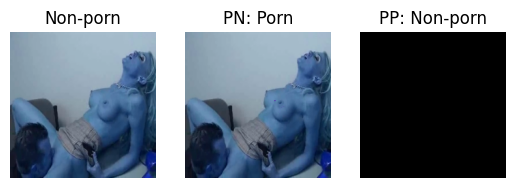

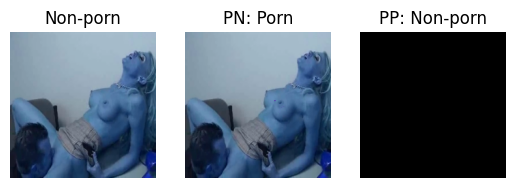

In [28]:
ce_explanation.plot(class_names=CLASS_NAMES)

In [ ]:
class_names = ["Non-porn", "Porn"]
def preprocess(inputs):
  return torch.stack([data_transforms(image=i.to_numpy().squeeze(0))["image"].requires_grad_() for i in inputs])

i = 1
for names, frames, _ in dataloader:
  if i == 0: break

  X, y = Image(frames.numpy(), batched=True), preds.numpy()

  inputs = preprocess(X).to(device)
  confs, preds = predict(model, inputs)
  for name, conf, pred in zip(names, confs, preds):
    print(f"{name} - predicted: {pred.item()} (confidence: {conf.item()})")

  sg = SmoothGrad(model, preprocess_function=preprocess)
  sg_explanation = sg.explain(X, y)
  sg_explanation.plot(class_names=CLASS_NAMES)

  i -= 1